###  Import the necessary libraries

In [15]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm


### Set time range

In [48]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365 * years)

### Create a list of tickers

In [49]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

### Download the daily adjusted close prices for the tickers

In [52]:
close_df = yf.download(tickers, start=startDate, end=endDate)['Close']
print(close_df.head())

[*********************100%***********************]  5 of 5 completed

Ticker            BND         GLD        QQQ        SPY        VTI
Date                                                              
2010-06-01  52.417515  119.910004  39.446400  81.714088  41.949680
2010-06-02  52.371826  119.779999  40.380608  83.841888  43.041748
2010-06-03  52.313072  117.959999  40.764771  84.130653  43.270866
2010-06-04  52.456703  119.190002  39.367813  81.174553  41.751118
2010-06-07  52.619911  121.489998  38.651871  80.163879  41.071430


### Calculate the daily log returns and drop NAs

In [53]:
log_returns_df = np.log(close_df / close_df.shift(1)).dropna()
print(log_returns_df.head())

Ticker           BND       GLD       QQQ       SPY       VTI
Date                                                        
2010-06-02 -0.000872 -0.001085  0.023407  0.025706  0.025700
2010-06-03 -0.001122 -0.015311  0.009469  0.003438  0.005309
2010-06-04  0.002742  0.010373 -0.034870 -0.035769 -0.035753
2010-06-07  0.003106  0.019113 -0.018353 -0.012529 -0.016413
2010-06-08 -0.000372 -0.004041 -0.001808  0.010655  0.008517


### Create an equally weighted portfolio

In [54]:
portfolio_value = 1000000
weights = np.array([1 / len(tickers)] * len(tickers))
print("Weights:", weights)

Weights: [0.2 0.2 0.2 0.2 0.2]


### Calculate the historical returns

In [56]:
historical_returns = (log_returns_df * weights).sum(axis=1)
print("Historical Returns:", historical_returns.head())

Historical Returns: Date
2010-06-02    0.014571
2010-06-03    0.000356
2010-06-04   -0.018655
2010-06-07   -0.005015
2010-06-08    0.002590
dtype: float64


### Find the day's historical returns

In [86]:
days = 5

range_returns = historical_returns.rolling(window=days).sum().dropna()
print("Range Returns:", range_returns.head())

Range Returns: Date
2010-06-08   -0.006153
2010-06-09   -0.025131
2010-06-10   -0.011519
2010-06-11    0.013287
2010-06-14    0.017349
dtype: float64


### Specify the confidence interval for VaR

In [91]:
confidence_level = 0.95

VaR = -np.percentile(range_returns, 100 - (confidence_level * 100)) * portfolio_value
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level: ${VaR:.2f}")

Value at Risk (VaR) at 95.0% confidence level: $24026.33


### Plot the results

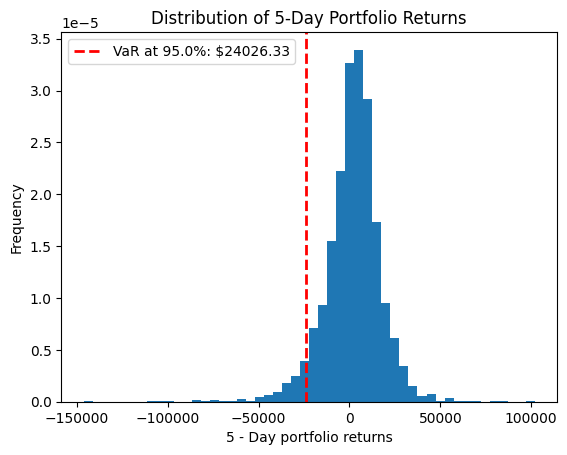

In [72]:
return_window = days
range_returns = historical_returns.rolling(window=days).sum().dropna()
range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window} - Day portfolio returns')
plt.ylabel('Frequency')
plt.title(f'Distribution of {return_window}-Day Portfolio Returns')
plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_level * 100}%: ${VaR:.2f}')
plt.legend()
plt.show()

### Variance and covariance

In [94]:
confidence_level = 0.95
Z = norm.ppf(1 - (1 - confidence_level))  # Z = 1.645 for 95%, 2.326 for 99%
T = 5
portfolio_value = 1000000

daily_volatility = historical_returns.std()

scaled_volatility = daily_volatility * np.sqrt(T)

parametric_VaR = Z * scaled_volatility * portfolio_value

VaR_return_level = -Z * scaled_volatility

print(f"Variance-Covariance VaR at {confidence_level*100:.0f}% confidence over {T} days: ${parametric_VaR:.2f}")

Variance-Covariance VaR at 95% confidence over 5 days: $27223.72


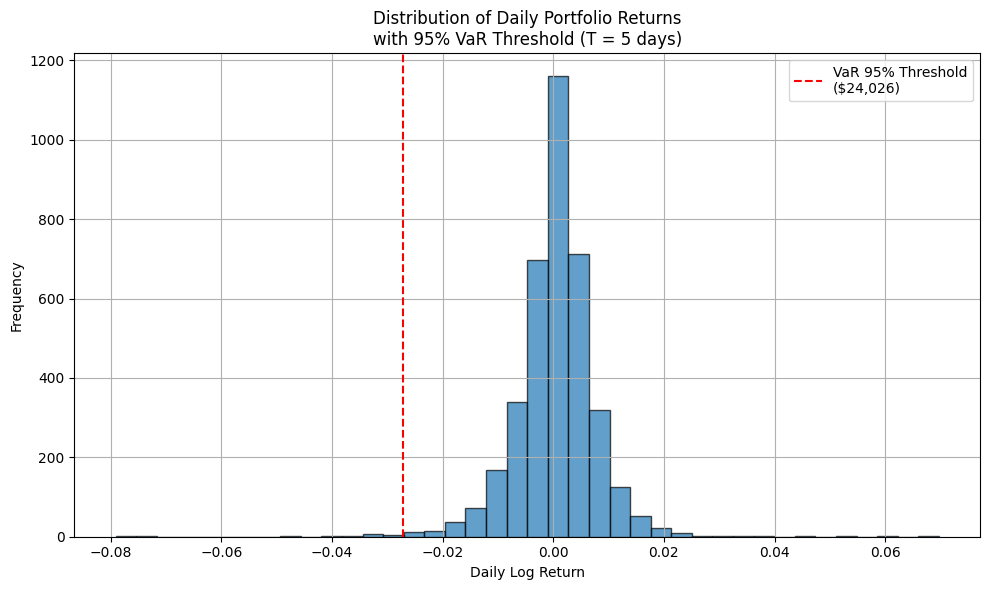

In [95]:
plt.figure(figsize=(10, 6))
plt.hist(historical_returns, bins=40, edgecolor='black', alpha=0.7)
plt.axvline(x=VaR_return_level, color='red', linestyle='--', label=f'VaR 95% Threshold\n(${VaR:,.0f})')

plt.title(f'Distribution of Daily Portfolio Returns\nwith 95% VaR Threshold (T = {T} days)')
plt.xlabel('Daily Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rolling VaR

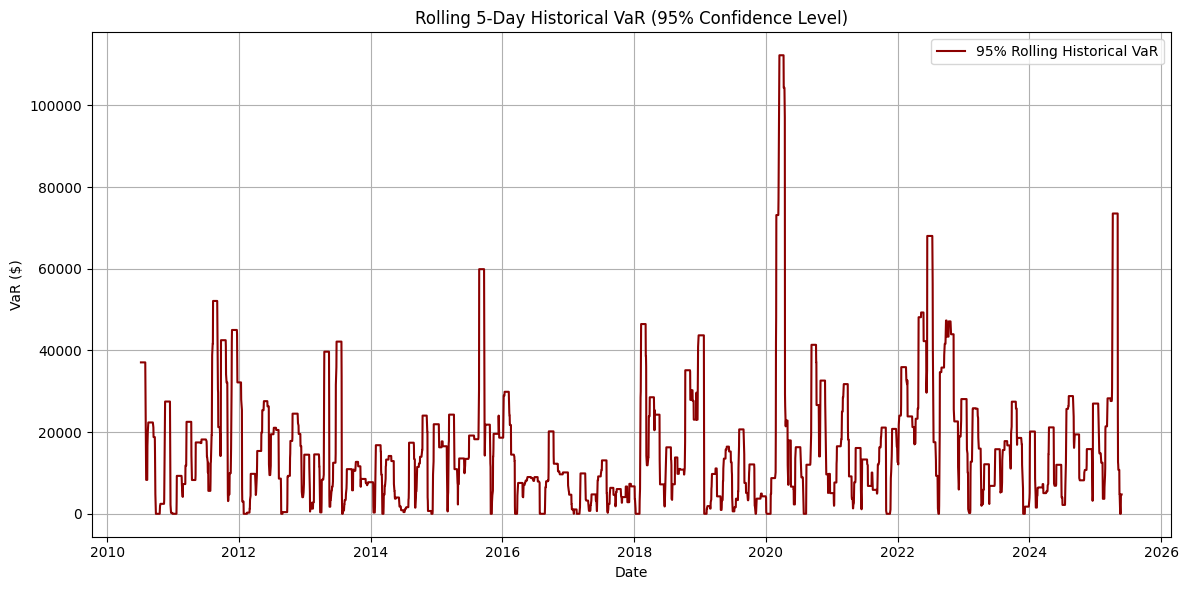

In [ ]:
confidence_level = 0.95
T = 5  # VaR time horizon (e.g., 5-day)
portfolio_value = 1000000  # total value of the portfolio in dollars
rolling_window = 20  # lookback window for historical VaR

# Step 1: Calculate 5-day rolling returns (sums of daily returns)
rolling_5day_returns = historical_returns.rolling(window=T).sum()

# Step 2: Compute rolling historical VaR (using quantile of rolling returns)
rolling_historical_VaR = rolling_5day_returns.rolling(window=rolling_window).quantile(1 - confidence_level)

# Step 3: Convert return-based VaR to dollar VaR
rolling_historical_VaR_dollar = -rolling_historical_VaR.clip(upper=0) * portfolio_value

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.plot(rolling_historical_VaR_dollar, label=f'{int(confidence_level*100)}% Rolling Historical VaR', color='darkred')
plt.title(f'Rolling {T}-Day Historical VaR (95% Confidence Level)')
plt.xlabel('Date')
plt.ylabel('VaR ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()